In [1]:
import os
import argparse
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch.autograd import Function
from torchvision import models

from NNUtils import CustomDataset
import glob
import tifffile as tiff

import errno
import imageio

from PIL import Image
from torch.utils import data
import torch.nn.functional as F
import torch.nn as nn

from NNLoss import dice_loss

In [2]:
# A simple hook class that returns the input and output of a layer during forward/backward pass
# reference: https://www.kaggle.com/sironghuang/understanding-pytorch-hooks
class Hook():
    def __init__(self, module, backward=False):
        if backward==False:
            self.hook = module.register_forward_hook(self.hook_fn)
        else:
            self.hook = module.register_backward_hook(self.hook_fn)
    def hook_fn(self, module, input, output):
        self.input = input
        self.output = output
    def close(self):
        self.hook.remove()

In [3]:
index = 50
# index = 80

device = torch.device('cuda')

test_data = '/home/moucheng/projects_data/Pulmonary_data/CARVE2014/cross_validation/dense_2_r176_s5/test'
test_data_images = test_data + '/patches'
test_data_labels = test_data + '/labels'
dataset = CustomDataset(test_data_images, test_data_labels, 'none', 3)

images1, images2, images3, labels, imagename = dataset[index]

testimg = images2

images1 = torch.from_numpy(images1).float().unsqueeze_(0).to(device=device)
images2 = torch.from_numpy(images2).float().unsqueeze_(0).to(device=device)
images3 = torch.from_numpy(images3).float().unsqueeze_(0).to(device=device)

# labels = torch.from_numpy(labels).float().unsqueeze_(0).requires_grad_(True).to(device=device)
labels = torch.from_numpy(labels).float().unsqueeze_(0).to(device=device)

In [4]:
# model = models.resnet50(pretrained=True)
model_name_ori = 'ERFAnetZ_repeat_1_augmentation_none_alpha_0.002_lr_2e-05_epoch_50annealing_down_at_0_beta_0.8_constraint_jacobi_all_gamma_0.2_CARVE2014_0_r176_s30_Final'
model_path = '/home/moucheng/PhD/MICCAI 2021/models/0s30/ERFAnetZ_repeat_1_augmentation_none_alpha_0.002_lr_2e-05_epoch_50annealing_down_at_0_beta_0.8_constraint_jacobi_all_gamma_0.2_CARVE2014_0_r176_s30/trained_models'

# model_name_ori = 'Unet_labelled_repeat_1_augmentation_all_lr_2e-05_epoch_50_CARVE2014_2_r176_s50_epoch49'
# model_path = '/home/moucheng/Desktop/IPMI results/CARVE2014/2_r176_s50/IPMI2020/Unet_labelled_repeat_1_augmentation_all_lr_2e-05_epoch_50_CARVE2014_2_r176_s50/trained_models'

model = model_name_ori + '.pt'
model = model_path + '/' + model

model = torch.load(model)
model.to(device=device)
model.eval()

NewERFAnet2(
  (econv0): Sequential(
    (0): Conv2d(1, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): InstanceNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
    (2): ReLU(inplace=True)
  )
  (econv1): Sequential(
    (0): Conv2d(24, 48, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): InstanceNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
    (2): ReLU(inplace=True)
    (3): Conv2d(48, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (4): InstanceNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
    (5): ReLU(inplace=True)
  )
  (econv2): Sequential(
    (0): Conv2d(48, 96, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): InstanceNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
    (2): ReLU(inplace=True)
    (3): Conv2d(96, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), b

In [9]:
# call modules:
# model.fpa2.main_branch[1]

# fpa:
hook_forward_fp = Hook(model.fpa1.main_branch)
hook_backward_fp = Hook(model.fpa1.main_branch, backward=True)

# fna:
# hook_forward_fn = Hook(model.fna0)
# hook_backward_fn = Hook(model.fna0, backward=True)

outputs_fp, outputs_fn, pseudo_x1_a, pseudo_x1_b, pseudo_x2, pseudo_x3_a, pseudo_x3_b, x_, x__, x___ = model(images1, images2, images3)
# outputs_fp, outputs_fn = model(images2)

prob_outputs_fp = torch.sigmoid(outputs_fp)
prob_outputs_fn = torch.sigmoid(outputs_fn)
out = (prob_outputs_fp + prob_outputs_fn) / 2

# outputs = model(images2)
# outputs = torch.sigmoid(outputs)

model.zero_grad()

# calculate class loss for backward the gradients:
loss = dice_loss(prob_outputs_fp, labels) + dice_loss(prob_outputs_fn, labels) + nn.MSELoss(reduction='mean')(prob_outputs_fp, prob_outputs_fn)
# loss = dice_loss(outputs, labels)

loss.backward()

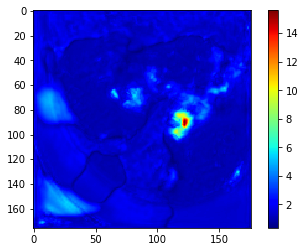

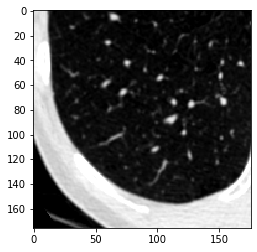

In [10]:
fmap_fp = hook_forward_fp.output.cpu().data.numpy().squeeze()
# fmap_fn = hook_forward_fn.output.cpu().data.numpy().squeeze()

# gradient = hook_backward.input.cpu().data.numpy().squeeze()

fmap_fp = np.max(fmap_fp, axis=0)
# fmap_fn = np.max(fmap_fn, axis=0)

# fmap_diff = fmap_fp - fmap_fn
# fmap_diff[fmap_diff < 0.9] = 0

plt.imshow(fmap_fp, cmap='jet')
plt.colorbar()
plt.show()

save_folder = '/home/moucheng/projects_codes/ERFNet/saliency_maps'
save_folder = save_folder + '/' + model_name_ori
save_saliency_map_name = save_folder + '/' + 'fna0_main_branch_' + imagename + '.png'

try:
    os.mkdir(save_folder)
except OSError as exc:
    if exc.errno != errno.EEXIST:
        raise
    pass

plt.imsave(save_saliency_map_name, fmap_fp, cmap="jet")
save_input_ct_name = save_folder + '/' + imagename + '.png'

plt.imsave(save_input_ct_name, testimg.squeeze(), cmap="gray")
plt.imshow(testimg.squeeze(), cmap='gray')
plt.show()